# Dataset 1: CM_SAF SARAH2.1 (Sunshine Duration Unit Feature Only)

In [1]:
import pandas
import pandas as pd
import pytz
import xarray as xr
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm

## Read in sunshine hours

### Read in NetCDF and convert to dataframes

In [2]:
path_to_netCDF_sunhours = "E:\ORD49239"
df_parts = []
for netcdf_file in tqdm(glob.glob(f"{path_to_netCDF_sunhours}\*")):
    ds_part = xr.open_dataset(netcdf_file, engine='netcdf4')
    df_parts.append(ds_part.to_dataframe())
    break # TODO: Remove after debugging

  0%|          | 0/192 [00:00<?, ?it/s]


### Handle NaNs

* Where do the NaNs come from: I assume they come from stations not recording values on a certain date. Since
we are interested in averages over countries as a whole, it should not pose an issue to drop them. This will also
reduce the number of rows.

In [3]:
test_df = df_parts[0].dropna().reset_index()
test_df.head()

,lon,lat,time,SDU
0,-65.0,-22.299999,2000-01-01,110.577332
1,-65.0,-22.250000,2000-01-01,114.464058
2,-65.0,-22.200001,2000-01-01,121.085159
3,-65.0,-22.150000,2000-01-01,120.345100
4,-65.0,-22.100000,2000-01-01,121.679955


### Reduce dataset size by excluding non-EU countries

We can do this by loading the world map, filtering out the EU countries
and then removing all coordinates outside the min-max square of the EU.

For this, the following shape file will be used to define coordinate bounds
between countries:

In [4]:
import geopandas as gpd

In [5]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world.continent == 'Europe']

#### Ignored countries (Blacklist)
In this section, we define countries to leave out of the processing by adding their country
codes in ISO_A3 to the list below:

In [6]:
ignored_countries = ['RUS']
europe = europe[~europe['iso_a3'].isin(ignored_countries)]

### Map coordinates to country

We use geopandas to merge the world borders with the dataset by long/lat

In [7]:
gdf = gpd.GeoDataFrame(test_df, geometry=gpd.points_from_xy(test_df.lon, test_df.lat))

Calculate median SDU (sunshine duration) per country in europe:

In [8]:
gdf_country = gpd.sjoin(gdf, europe, how='inner')
gdf_country.head()

C:\Users\phili\AppData\Local\Temp\ipykernel_17504\2981836489.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf_country = gpd.sjoin(gdf, europe, how='inner')


,lon,lat,time,SDU,geometry,index_right,pop_est,continent,name,iso_a3,gdp_md_est
278892,-54.500000,2.35,2000-01-01,138.491837,POINT (-54.50000 2.35000),43,67059887.0,Europe,France,FRA,2715518
280560,-54.450001,2.30,2000-01-01,140.067657,POINT (-54.45000 2.30000),43,67059887.0,Europe,France,FRA,2715518
280561,-54.450001,2.35,2000-01-01,139.915192,POINT (-54.45000 2.35000),43,67059887.0,Europe,France,FRA,2715518
280562,-54.450001,2.40,2000-01-01,135.425186,POINT (-54.45000 2.40000),43,67059887.0,Europe,France,FRA,2715518
280607,-54.450001,4.65,2000-01-01,153.570526,POINT (-54.45000 4.65000),43,67059887.0,Europe,France,FRA,2715518


In [9]:
gdf_country_median = gdf_country.groupby('name').median().loc[:, ['SDU']]
gdf_country_median.head()

,SDU
name,
Albania,166.964035
Austria,68.798660
Belarus,33.689892
Belgium,58.523132
Bosnia and Herz.,87.071968


### Create a cloropleth plot for SDU

In [10]:
merged = europe.set_index('name').join(gdf_country_median)
merged.head()

,pop_est,continent,iso_a3,gdp_md_est,geometry,SDU
name,,,,,,
Norway,5347896.0,Europe,NOR,403336,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...",8.169410
France,67059887.0,Europe,FRA,2715518,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",87.718155
Sweden,10285453.0,Europe,SWE,530883,"POLYGON ((11.02737 58.85615, 11.46827 59.43239...",27.591003
Belarus,9466856.0,Europe,BLR,63080,"POLYGON ((28.17671 56.16913, 29.22951 55.91834...",33.689892
Ukraine,44385155.0,Europe,UKR,153781,"POLYGON ((32.15944 52.06125, 32.41206 52.28869...",42.825497


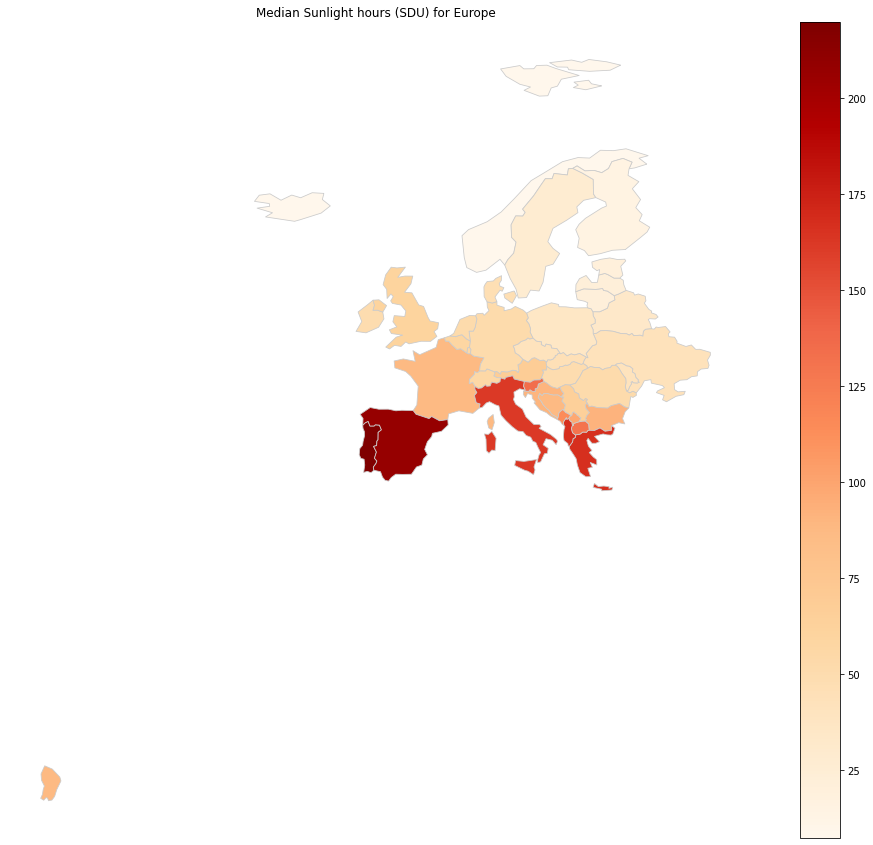

In [11]:
fig, ax = plt.subplots(1, figsize=(20, 15))
merged.plot(column='SDU', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.axis('off')
plt.title("Median Sunlight hours (SDU) for Europe");

# Dataset 2: Sun phases (Sunrise-Sunset) creation via Astral package

In [12]:
from astral.geocoder import database, lookup
from astral import sun
from unidecode import unidecode
from countryinfo import CountryInfo

First, get all capital cities for all EU countries, as the astral library works on capitals only:

In [13]:
country = CountryInfo()
iso_to_cap = {v['ISO']['alpha3']: v['capital'] for k,v in country.all().items() if 'capital' in v.keys()}

In [14]:
iso_to_cap_EU = {k:v for k,v in iso_to_cap.items() if k in europe['iso_a3'].tolist()}

In [15]:
# Normalize capital names
iso_to_cap_EU_norm = {k:unidecode(v) for k,v in iso_to_cap_EU.items()}

Get sunset and sunrise data for all European countries.
Times are all in UTC.
We convert the results to a dataframe with separate columns for the year, month and day columns.
The format is as follows:
Country code (ISO_A3), City, Day, Month, Year, Sunrise Hour (24h UTC), Sunset Hour (24h UTC)

This will allow the aggregation over days, months, years, etc. to build visualizations on top of.

In [16]:
import pandas as pd

dates = pd.date_range(start='2022-01-01', end='2022-12-31').to_pydatetime()

In [17]:
sun_data = []
for country_isoa3,capital in iso_to_cap_EU_norm.items():
    city = lookup(capital, database())
    for d in dates:
        try:
            sunrise = sun.sunrise(observer=city.observer, date=d)
            sunset = sun.sunset(observer=city.observer, date=d)
            sun_data.append([country_isoa3, capital, d.day, d.month, d.year, sunrise.hour, sunset.hour])
        except ValueError:
            print(f"Could not process day {d}")

Could not process day 2022-06-16 00:00:00


In [18]:
sun_info_df = pd.DataFrame(sun_data, columns=['iso_a3', 'capital', 'day', 'month', 'year', 'sunrise_UTC', 'sunset_UTC'])

### Create a cloropleth plot for the sunrise/sunset

First we will have to merge the df with the europe geo dataframe again:

In [19]:
europe_plot = europe.loc[:, ['iso_a3', 'geometry']]

In [20]:
sun_info_plot = gpd.GeoDataFrame(sun_info_df.merge(europe_plot, on='iso_a3', how='left').set_index('iso_a3'))
sun_info_plot.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 13139 entries, ALB to GBR
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   capital      13139 non-null  object  
 1   day          13139 non-null  int64   
 2   month        13139 non-null  int64   
 3   year         13139 non-null  int64   
 4   sunrise_UTC  13139 non-null  int64   
 5   sunset_UTC   13139 non-null  int64   
 6   geometry     13139 non-null  geometry
dtypes: geometry(1), int64(5), object(1)
memory usage: 1.3+ MB


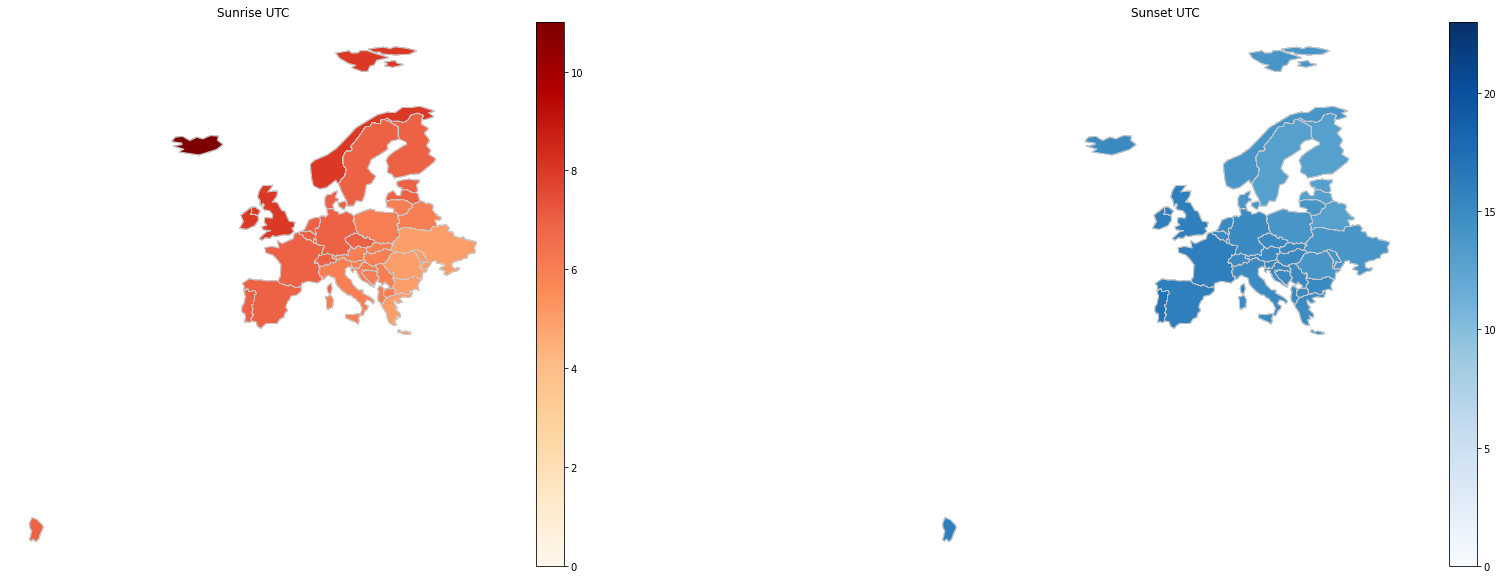

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
sun_info_plot.plot(column='sunrise_UTC', cmap='OrRd', linewidth=0.8, ax=axs[0], edgecolor='0.8', legend=True)
sun_info_plot.plot(column='sunset_UTC', cmap='Blues', linewidth=0.8, ax=axs[1], edgecolor='0.8', legend=True)
for a in axs:
    a.axis('off')
axs[0].set_title('Sunrise UTC')
axs[1].set_title('Sunset UTC');

# Exploring distance to Timezones

Since we have to get a measure for a whole country somehow, we take the largest 3 cities (based on population size)
from each EU country using the Eurostat Urban Audit dataset. For these cities we can then calculate the distance
to the time meridian to the east using the coordinates of both (~1 degree of lat ~ 111 km).

### Urban Audit City Population dataset

In [22]:
eu_cities_pop = pd.read_csv('datasets/Eurostat/urban_population/urb_cpop1_page_tabular.tsv', sep='\t', header=0)
city_codes = pd.read_excel('datasets/Eurostat/urban_population/urb_esms_an4.xlsx', dtype=str)

Split up the identifier into country (ISO_A2) and city code.
We also need to handle to conversion of weird population numbers with d,e,... at the end to integers.
I assume those are identifiers on how the data was collected, which we can gladly ignore as we just
need geographical points of reference for our visualization later on.

In [23]:
eu_cities_pop.columns = ['code_info','population']
eu_cities_pop['population'] = eu_cities_pop['population'].apply(lambda x: int(x.split(' ')[0]))
eu_cities_pop['CODE'] = eu_cities_pop.iloc[:,0].apply(lambda x: x.split(',')[-1])
eu_cities_pop['country_ISO_A2'] = eu_cities_pop['CODE'].apply(lambda x: x[0:2])

In [24]:
eu_cities = eu_cities_pop.merge(city_codes, on='CODE')
eu_cities = eu_cities.iloc[:,1:]
eu_cities = eu_cities[eu_cities_pop['CODE'].apply(lambda x: len(x) > 2)]

In [25]:
TOP_N_COUNTRIES = 3
top_3_cities_per_country = eu_cities.groupby('country_ISO_A2').apply(lambda x: x.nlargest(TOP_N_COUNTRIES, 'population')).reset_index(drop=True)
top_3_cities_per_country.head()

,population,CODE,country_ISO_A2,NAME
0,1205492,BE001C,BE,Bruxelles/Brussel
1,523591,BE002C,BE,Antwerpen
2,383710,BE005C,BE,Liège
3,1238438,BG001C,BG,Sofia
4,345213,BG002C,BG,Plovdiv


### Adding geographical information
We will now use **geopy** to add geographical information (lat,lon) of
each of the cities we got from the Urban Audit dataset.

In [71]:
from geopy.geocoders import Nominatim
from timezonefinder import TimezoneFinder
from pytz import timezone
from datetime import datetime

geolocator = Nominatim(user_agent='CircadianRythmEU')
tf = TimezoneFinder()

In [27]:
def get_geo_location(x):
    city_name = f"{x['NAME']}, {x['country_ISO_A2']}"
    try:
        geo_info = geolocator.geocode(city_name)
        return geo_info.longitude, geo_info.latitude
    except AttributeError:
        return None, None

In [28]:
geo_city_df = top_3_cities_per_country.apply(lambda x: get_geo_location(x), axis='columns', result_type='expand')

In [38]:
geo_city_df.columns = ['longitude','latitude']
top_cities_geo = pd.concat([top_3_cities_per_country, geo_city_df], axis=1)
top_cities_geo = top_cities_geo.dropna()

### Adding timezone information and distance to nearest timezone border
It is important to know, that we are interested only in the **physical sun-based** timezones for this!!

In [98]:
dt_now = datetime.now()

ADJUST_LOCAL_SUMMERTIME = True
LONGITUDE_DEGREE_KM_RATIO = 80

def _add_tz_info(x):
    long = x['longitude']
    lat = x['latitude']
    tz_name = tf.timezone_at(lng=long, lat=lat)
    utc_offset = timezone(tz_name).utcoffset(dt_now, is_dst=True).total_seconds()/60/60

    # Subtract one hour so the timezone of Europe/London is 0 --> All others are fine then too
    # THis works since we are interested in the sun-based timezones only for this
    if ADJUST_LOCAL_SUMMERTIME:
        utc_offset -= 1

    # Get longitudinal meridian values for each timezone --> 15 degrees per tz (360 deg / 24 hours)
    # We then calculate the distance to it similar to [Trang Vophan et. al 2018]
    meridian_east = 15 * utc_offset
    long_diff = meridian_east - long
    long_diff_km = LONGITUDE_DEGREE_KM_RATIO * long_diff

    return tz_name, utc_offset, long_diff, long_diff_km

def get_timezone_data(top_city_data: pd.DataFrame) -> pd.DataFrame:
    # Load timezones and offsets
    tz_geo_info = top_city_data.apply(lambda x: _add_tz_info(x), axis='columns', result_type='expand')
    tz_geo_info.columns = ['social_timezone', 'utc_sun_timezone_offset', 'longitudinal_diff', 'longitudinal_diff_km']

    # Check if adjustment was correct, if not, maybe look at if summertime is active in you current location
    london_tz = tz_geo_info[tz_geo_info['social_timezone'] == 'Europe/London']
    assert all(london_tz['utc_sun_timezone_offset'] == 0)

    return tz_geo_info

In [99]:
tz_geo_data = get_timezone_data(top_cities_geo)

In [103]:
top_cities_geo_tz = pd.concat([top_cities_geo, tz_geo_data], axis=1)
top_cities_geo_tz.head()

,population,CODE,country_ISO_A2,NAME,longitude,latitude,social_timezone,utc_sun_timezone_offset,longitudinal_diff,longitudinal_diff_km
0,1205492,BE001C,BE,Bruxelles/Brussel,4.351697,50.846557,Europe/Brussels,1.0,10.648303,851.864240
1,523591,BE002C,BE,Antwerpen,4.399708,51.221110,Europe/Brussels,1.0,10.600292,848.023352
2,383710,BE005C,BE,Liège,5.573611,50.645094,Europe/Brussels,1.0,9.426389,754.111104
3,1238438,BG001C,BG,Sofia,23.321736,42.697703,Europe/Sofia,2.0,6.678264,534.261128
4,345213,BG002C,BG,Plovdiv,24.749930,42.141854,Europe/Sofia,2.0,5.250070,420.005624
